# Objectives: Solving problems proposed in the Bayesianx interview.

---
## Value proposition
The objective of this exercise is to analyze the prices of the products of an e-commerce company that has hired us, in order to determine whether their prices are competitive compared to the products offered by other companies.

On the other hand, revenues for the following month will also be estimated.

## Motivations for solving this exercise:

- **Identify improvement opportunities**: Detect products with non-competitive prices to adjust pricing strategies and improve market positioning.

- **Increase competitiveness**: Help the company attract more customers by offering prices more aligned with market standards.

- **Optimize profit margins**: Balance competitive pricing with profit margins to maximize financial returns.

- **Benchmarking**: Provide a clear view of the company’s positioning relative to its direct competitors.

---
## Sources of data
The data used in this exercise has been partially provided by the contracting company, including relevant information about the products they offer, such as prices, categories, transactions, and additional features.

Additionally, to enrich the analysis and provide a competitive context, external data was obtained using web scraping techniques. This process generated the file competitors_products_v2.json, which contains information about the price, product name, and the name of the company offering these products.

---

<a id='index'></a>
## Index

[Importing libraries](#libraries)<br>


## Solving the first problem: Price comparison
[Data Understanding and Preparation](#preparation)<br>
[Fuzzywuzzy aplication](#fuzzy)<br>


## Solving the second problem: Predicting revenue
[Data Understanding](#understanding)<br>
[Model implementation](#model)<br>


<a id='libraries'></a>
# Importing libraries
[Back to index](#index)

In this section we import the main libraries and methods that we will use throughout the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import re

plt.style.use('ggplot')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import statsmodels.api as sm

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# SOLVING THE FIRST PROBLEM: Price comparison

<a id='preparation'></a>
## Data Understanding and Preparation
[Back to index](#index)

En este apartado importamos los datasets necesarios para construir el dataset que finalmente usaremos. Una vez importados, se nos pide comparar los productos de nuestra empresa con los productos de la empresa que menos productos ofrece.

In [2]:
# open the json file
with open('competitors_products_v2.json', 'r') as archivo:
    datos = json.load(archivo)

# data are now in a dictionary
#print(datos)

In [3]:
dataframes = {}
for company, products in datos.items():
    df = pd.DataFrame(products)
    df['company'] = company  # Add a column with the company name
    dataframes[company] = df

In [4]:
dataframes

{'BargainBay':                                           product_name     price     company
 0    VS Club B Alphabet Initial Letter Leather Meta...        11  BargainBay
 1                Daniel Klein Analog Gold Dial Women's        86  BargainBay
 2    The Purani Jeans College Bags For Girls Stylis...        35  BargainBay
 3    Imperative Neu Look Women's Color Block Stretc...        17  BargainBay
 4                                travel360 degree Neck        15  BargainBay
 ..                                                 ...       ...         ...
 401    HIGH TOUCH Leather Metal Handle Women's Handbag        46  BargainBay
 402                          Ferro Spezia Analog Black       187  BargainBay
 403       AZONE Pro 42x10Cricket Net 10 mx3 m (420 Sqr  21&quot;  BargainBay
 404  Vikas Fashions Soft Satin Georgette Plain Sare...        36  BargainBay
 405        Parker Moments Vector Gold Trim Roller Ball         8  BargainBay
 
 [406 rows x 3 columns],
 'BestGoods':          

In [5]:
# here we have the names of the competitor companies
dataframes.keys()

dict_keys(['BargainBay', 'BestGoods', 'ClickCart', 'CompetitorX', 'DailyDeals', 'DiscountHub', 'FastBargain', 'GlobalMart', 'MegaMart', 'PrimeBazaar', 'QuickBuy', 'RetailRocket', 'Shop360', 'ShopEase', 'ShopZone', 'SmartCart', 'SuperDepot', 'TrendyStore', 'UltraShop', 'ValueMarket'])

In [6]:
# example
dataframes['BargainBay'].head()

,product_name,price,company
0,VS Club B Alphabet Initial Letter Leather Meta...,11,BargainBay
1,Daniel Klein Analog Gold Dial Women's,86,BargainBay
2,The Purani Jeans College Bags For Girls Stylis...,35,BargainBay
3,Imperative Neu Look Women's Color Block Stretc...,17,BargainBay
4,travel360 degree Neck,15,BargainBay


In [7]:
# we look for the company that has the lowest number of products

less_products = min(dataframes, key=lambda company: dataframes[company].shape[0])
less_products_company = dataframes[less_products]

print(f" The company with the least number of products is {less_products_company['company'].unique()} with {less_products_company.shape[0]} products")

 The company with the least number of products is ['DailyDeals'] with 366 products


In [8]:
less_products_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  366 non-null    object
 1   price         366 non-null    object
 2   company       366 non-null    object
dtypes: object(3)
memory usage: 8.7+ KB


In [9]:
less_products_company.describe(exclude=np.number).T

,count,unique,top,freq
product_name,366,364,Maxima Max Pro X4+ Rugged Bluetooth Calling Sm...,2
price,366,107,5,19
company,366,1,DailyDeals,366


In [10]:
pd.options.display.max_rows = 150
#pd.DataFrame(less_products_company['price'].value_counts(dropna = False))

In [11]:
# list of non desired elements
non_desired = ['r/', '&amp;', '&nbsp;','&#39;']

# Función para eliminar solo si se encuentra un valor no deseado
def clean_price(value, non_desired):
    if isinstance(value, str):  # Verifica si el valor es un string
        for element in non_desired:
            value = value.replace(element, '')
    return value

# Eliminar los elementos no deseados solo si están presentes
less_products_company['price'] = less_products_company['price'].apply(lambda x: clean_price(x, non_desired))

#pd.DataFrame(less_products_company['price'].value_counts(dropna = False))
less_products_company['price'] = less_products_company['price'].astype(float)    

# Convert ‘product_name’ to lowercase to save fuzzywuzzy processing time in the future
less_products_company['product_name'] = less_products_company['product_name'].str.lower()

Once we have properly processed the product data from the company we want to compare with, we will prepare an identical DataFrame containing the product name and price of our company's products, so that we can later compare them.

In [12]:
our_products = pd.read_csv('products_v2.csv')

In [13]:
our_products.head()

,product_id,name,main_category,sub_category,ratings,no_of_ratings,price (USD),cost (USD)
0,bx-000JHG,The Shopoholic Analog Black Rectangle Dial Wom...,accessories,Watches,NaN,NaN,6.0,4.3
1,bx-000Y0V,GROOT Professional Analog Black Color Dial Men...,accessories,Watches,NaN,NaN,12.0,9.7
2,bx-002PVJ,BIGXEN Kids Mask Cotton Mask for Boys and Girl...,accessories,Bags & Luggage,4.2,31,4.0,1.2
3,bx-003PYP,Kawaii Kart | Lightstick Keychain | Premium 3D...,accessories,Bags & Luggage,3.7,13,24.0,18.6
4,bx-0042LQ,NEUTRON Heart Analog Grey and Black Color Dial...,accessories,Watches,NaN,NaN,12.0,3.5


In [14]:
our_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18938 entries, 0 to 18937
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     18938 non-null  object 
 1   name           18938 non-null  object 
 2   main_category  18900 non-null  object 
 3   sub_category   18900 non-null  object 
 4   ratings        14865 non-null  object 
 5   no_of_ratings  14865 non-null  object 
 6   price (USD)    18652 non-null  float64
 7   cost (USD)     18938 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.2+ MB


In [15]:
our_products.describe(exclude=np.number).T

,count,unique,top,freq
product_id,18938,18937,bx-82TQVA,2
name,18938,18938,The Shopoholic Analog Black Rectangle Dial Wom...,1
main_category,18900,6,accessories,9999
sub_category,18900,9,Watches,5122
ratings,14865,42,4.0,1488
no_of_ratings,14865,2474,1,1048


In [16]:
# vemos el número de nulos que tenemos en cada columna

col_null = our_products.isna().sum()
col_with_null = col_null[col_null>0]
col_with_null

main_category      38
sub_category       38
ratings          4073
no_of_ratings    4073
price (USD)       286
dtype: int64

We will now analyse the nulls in the price, main_category and sub_category columns. The nulls of no_of_ratings and ratings will not be imputed because our exercise does not require it.

In [17]:
our_products[our_products['main_category'].isna()].head(20)

,product_id,name,main_category,sub_category,ratings,no_of_ratings,price (USD),cost (USD)
1156,bx-0MHDKY,"TULMAN Checks,Strip 9 Cms Cosmetic Pouch (S_Ch...",NaN,NaN,NaN,NaN,NaN,0.0
2514,bx-1DVVQD,Sun Fashion And Lifestyle woven dress material...,NaN,NaN,NaN,NaN,NaN,0.0
2599,bx-1FQLAI,KINZILLA Shopping Trolley Bag with Wheels Coll...,NaN,NaN,NaN,NaN,NaN,0.0
2691,bx-1HKP6U,Zacharias Women's Fishermen Bucket Cotton Prin...,NaN,NaN,NaN,NaN,NaN,0.0
2991,bx-1NCY5P,KANCHNAR Women's Bhagalpuri Silk Printed Dupat...,NaN,NaN,NaN,NaN,NaN,0.0
3398,bx-1V816F,Kriwin Small Size Pack of 50 Pieces Silk Tissu...,NaN,NaN,NaN,NaN,NaN,0.0
3805,bx-238BRL,SILVER STORK Women's Cotton Plain Hipster Pant...,NaN,NaN,NaN,NaN,NaN,0.0
4075,bx-28CAW5,Epson 003 65ml Ink Bottle (Magenta),NaN,NaN,NaN,NaN,NaN,0.0
4078,bx-28DX54,INDO ERA Women's Cotton Blend,NaN,NaN,NaN,NaN,NaN,0.0
4293,bx-2COB1V,BRUSTRO Technical Pen (Set of 9) (Includes: 1 ...,NaN,NaN,NaN,NaN,NaN,0.0


In [18]:
our_products[our_products['main_category'].isna()]['product_id'].to_list()

['bx-0MHDKY',
 'bx-1DVVQD',
 'bx-1FQLAI',
 'bx-1HKP6U',
 'bx-1NCY5P',
 'bx-1V816F',
 'bx-238BRL',
 'bx-28CAW5',
 'bx-28DX54',
 'bx-2COB1V',
 'bx-2FOBMF',
 'bx-30YUP4',
 'bx-36LYJY',
 'bx-3LK0T1',
 'bx-3PG0J7',
 'bx-3WQQ4A',
 'bx-4JF7SR',
 'bx-5BKWI3',
 'bx-5UC24P',
 'bx-5X9MDH',
 'bx-5Y85QB',
 'bx-79Y9G8',
 'bx-7XD8PO',
 'bx-85G6BD',
 'bx-89O8BN',
 'bx-8D3490',
 'bx-8FAGUM',
 'bx-8GDI02',
 'bx-8J612R',
 'bx-8KJNZS',
 'bx-8RSDU4',
 'bx-8U32QL',
 'bx-8Z28UU',
 'bx-94WD3F',
 'bx-98X9TF',
 'bx-9LGGI2',
 'bx-9WZJB2',
 'bx-A7POWJ']

We assume that we don't have data for these products because they have not been sold, which is why we have created a list with their product_id to report it to the relevant department. So for this exercise, we could remove them.

In [19]:
our_products[our_products['price (USD)'].isna()]

,product_id,name,main_category,sub_category,ratings,no_of_ratings,price (USD),cost (USD)
256,bx-04WJPQ,Lacoste Lacoste.12.12 Analog White Dial Women'...,accessories,Watches,3.6,3,NaN,0.0
264,bx-0510S3,sindhwani ENTERPRISE0S.Yoga and Exercise mat o...,sports & fitness,Fitness Accessories,NaN,NaN,NaN,0.0
282,bx-05GYW5,TIMEX Analog Brown Dial Women's Watch-TW000W218,accessories,Watches,4.0,1,NaN,0.0
288,bx-05KYVI,Protoner PRO666 WSG Badminton Net,sports & fitness,Badminton,2.0,1,NaN,0.0
457,bx-08M5DQ,TIMEX Analog Silver Dial Women's Watch - TW0TL...,accessories,Watches,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
18703,bx-A4N7RZ,Women's Rayon Printed with Gotta Work Anarkali...,women's clothing,Clothing,3.0,1,NaN,0.0
18789,bx-A6AWKQ,Peterman Women Printed Zari Embroidery Kurta a...,women's clothing,Clothing,3.0,1,NaN,0.0
18853,bx-A7POWJ,"Tukzer Stylus Pen, iPad Pencil with Palm Rejec...",NaN,NaN,NaN,NaN,NaN,0.0
18859,bx-A7URAI,Michael-KorsAnalog Mother of Pearl Dial Women'...,accessories,Watches,NaN,NaN,NaN,0.0


We observe that the missing prices are due to the fact that there have been no sales this year (we searched to see if these products are in transactions and found that there are none), so for the problem that concerns us, we could eliminate these rows. We could also ask the company to provide us with data from previous years in which these products have been sold, as they have reviews.

In [20]:
products = our_products[['name','price (USD)']]
competitor = less_products_company
products= products.rename(columns={'name': 'product_name', 'price (USD)': 'price'})

# Convert ‘product_name’ to lowercase to save fuzzywuzzy processing time in the future
products['product_name'] = products['product_name'].str.lower()

In [21]:
products

,product_name,price
0,the shopoholic analog black rectangle dial wom...,6.0
1,groot professional analog black color dial men...,12.0
2,bigxen kids mask cotton mask for boys and girl...,4.0
3,kawaii kart | lightstick keychain | premium 3d...,24.0
4,neutron heart analog grey and black color dial...,12.0
...,...,...
18933,bellina women's shoulder bag with wallet (set ...,19.0
18934,u.s. polo assn. tripolis men's solid dk brown ...,22.0
18935,fastrack analog grey dial women's watch-nk6156...,25.0
18936,"nishi® waterproof backpack, girls & women styl...",11.0


In [22]:
competitor

,product_name,price,company
0,urban classic lady swiss made quartz,107.0,DailyDeals
1,oraah thyroid tea for hypothyroidism- restore ...,4.0,DailyDeals
2,neutron professional analog silver and rose go...,9.0,DailyDeals
3,chimera genuine leather multipurpose travel or...,26.0,DailyDeals
4,daevish women's,26.0,DailyDeals
...,...,...,...
361,thegiftkart shockproof crystal clear oppo f11 ...,9.0,DailyDeals
362,homefox jute bag for lunch tiffin with zip pla...,14.0,DailyDeals
363,g mall women's shoulder sling printed waterpro...,12.0,DailyDeals
364,casio hr-8rc-bk 150 steps check & correct prin...,32.0,DailyDeals


In [ ]:
# function to remove special characters from the columns we select
def remove_special_characters(df, columns):
    """
    Elimina los caracteres especiales de las columnas especificadas del DataFrame,
    conservando los espacios.
    
    Args:
    - df (pd.DataFrame): DataFrame a modificar.
    - columns (list): Lista de nombres de columnas donde se eliminarán los caracteres especiales.
    
    Returns:
    - pd.DataFrame: DataFrame con las columnas especificadas limpiadas.
    """
    pattern = '[^A-Za-z0-9\\s]'
    
    for column in columns:
        if column in df.columns:
            df[column] = df[column].astype(str).apply(lambda x: re.sub(pattern, '', x))
    
    return df

products= remove_special_characters(products, 'product_name')
competitor= remove_special_characters(competitor, 'product_name')

<a id='fuzzy'></a>
## Fuzzywuzzy aplication
[Back to index](#index)

In this section, we apply fuzzywuzzy to identify our products with the competitors' products, allowing us to compare them effectively in a DataFrame.

In [24]:
df_our = products
df_competitor = competitor


def match_products(df_our, df_competitor, threshold=80):
    matched_data = []

    for _, row_our in df_our.iterrows():
        our_product_name = row_our['product_name']
        our_price = row_our['price']
        
        best_match = process.extractOne(our_product_name, df_competitor['product_name'], scorer=fuzz.ratio)
        
        if best_match and best_match[1] >= threshold:  
            competitor_product_name = best_match[0]
            competitor_price = df_competitor[df_competitor['product_name'] == competitor_product_name]['price'].values[0]
            matched_data.append([our_product_name, competitor_product_name, our_price, competitor_price])
    
    df_matched = pd.DataFrame(matched_data, columns=['our_product_name', 'competitor_product_name', 'our_price', 'competitor_price'])
    return df_matched

df_comparison = match_products(df_our, df_competitor)

In [25]:
df_comparison.head(20)

,our_product_name,competitor_product_name,our_price,competitor_price
0,neutron heart analog grey and black color dial...,neutron quartz analog white color dial women w...,12.0,9.0
1,neutron diwali analog white color dial women w...,neutron quartz analog white color dial women w...,11.0,9.0
2,neutron heart analog black and rose gold color...,neutron wrist analog black and brown color dia...,10.0,11.0
3,neutron stylish 0 and analog black and white c...,neutron model 0 and analog black and silver co...,7.0,6.0
4,neutron rich analog black and white color dial...,neutron wrist analog black and brown color dia...,8.0,11.0
5,moonlight enterprise blue diamond studded silv...,moonlight enterprise blue diamond studded silv...,12.0,10.0
6,rps fashion with device of r analogue men's/bo...,rps fashion with device of r luxury analogue w...,16.0,11.0
7,daniel klein analog green dial women's watch-d...,daniel klein analog silver dial women's watch-...,100.0,32.0
8,glive's waterproof travel accessories passport...,glive's waterproof travel accessories passport...,6.0,8.0
9,neutron casual analog black and red color dial...,neutron professional analog black and red colo...,11.0,15.0


In [26]:
df_comparison['price_difference'] = df_comparison['our_price'] - df_comparison['competitor_price']

overpriced = df_comparison.sort_values(by = 'price_difference',ascending= False)
underpriced = df_comparison.sort_values(by = 'price_difference',ascending= True)

In [27]:
overpriced.head(10)

,our_product_name,competitor_product_name,our_price,competitor_price,price_difference
821,nasher miles goa hard-sided polypropylene lugg...,nasher miles bruges hard-sided polypropylene l...,576.0,180.0,396.0
1050,nasher miles bruges hard-sided polypropylene l...,nasher miles bruges hard-sided polypropylene l...,408.0,180.0,228.0
1216,nasher miles bruges hard-sided polypropylene l...,nasher miles bruges hard-sided polypropylene l...,360.0,180.0,180.0
345,nasher miles paris hard-sided polypropylene lu...,nasher miles bruges hard-sided polypropylene l...,360.0,180.0,180.0
492,michael kors womens 43 mm camille white dial s...,michael kors womens camille white dial stainle...,264.0,123.0,141.0
1241,daniel klein analog silver dial unisex adult w...,daniel klein analog silver dial women's watch-...,157.0,32.0,125.0
1086,"fossil gen 4(40mm, brown) ventura leather touc...","fossil gen 4(40mm, brown) ventura leather touc...",264.0,150.0,114.0
513,daniel klein analog silver dial women's watch-...,daniel klein analog silver dial women's watch-...,130.0,32.0,98.0
241,nasher miles nicobar hard-sided polypropylene ...,nasher miles bruges hard-sided polypropylene l...,276.0,180.0,96.0
1170,"samsung galaxy m13 (aqua green, 6gb, 128gb sto...","samsung galaxy m13 5g (stardust brown, 4gb, 64...",216.0,122.0,94.0


In [28]:
underpriced.head(10)

,our_product_name,competitor_product_name,our_price,competitor_price,price_difference
105,"mi 10t 5g cosmic black, 8gb ram, 128gb storage...","mi 10t 5g cosmic black, 8gb ram, 128gb storage...",516.0,774.0,-258.0
631,guess women's stainless steel petite vintage i...,guess women's stainless steel petite vintage i...,233.0,336.0,-103.0
955,beurer mg 280 yoga & stretch mat with 7 air ch...,beurer mg 280 yoga & stretch mat with 7 air ch...,385.0,470.0,-85.0
216,women's diamond automatic mechanical rose gold...,women's diamond automatic mechanical rose gold...,262.0,322.0,-60.0
473,seagate one touch 1tb external hdd with passwo...,seagate one touch 2tb external hdd with passwo...,60.0,113.0,-53.0
503,vaividhyam women's kanchipuram cotton saree wi...,women's pure cotton saree with blouse piece,8.0,54.0,-46.0
173,toshiba canvio ready 1tb portable external hdd...,toshiba canvio ready 1tb portable external hdd...,83.0,124.0,-41.0
643,safari tiffany polycarbonate 55 cms printed ha...,safari tiffany polycarbonate 55 cms printed ha...,88.0,128.0,-40.0
1201,men's watch - thin minimalist 42mm large dial ...,men's watch - thin minimalist 42mm large dial ...,150.0,188.0,-38.0
800,corsair vengeance lpx 8gb ddr4 3000 (pc4-24000...,corsair vengeance lpx 8gb ddr4 3000 (pc4-24000...,83.0,121.0,-38.0


We can see that each item in our company has been assigned a product from the competing company. However, many of the products will not be exactly the same as those in our company, but will simply belong to the same category or type. Therefore, when there is a large price difference, we must ensure which products we are comparing.

## Solving the second problem: Predicting revenue

In this section, we first understand the problem and analyze how the revenues have been distributed throughout the year, broken down by month. We visualize the revenues obtained in each of the months, both in general (for the entire company) and for each product category. This helps us to identify seasonal trends or specific product patterns. Next, we implement a prediction model to estimate the revenues for the following month (in this case, January 2025). We also analyze how the revenues are distributed across different product categories in that same month.

Finally, we will check if the sum of the revenues predicted for each category in January 2025 is close to the total projected revenues for that month. This way, we can validate whether the model provides reliable estimates and whether the contributions of each category to the total revenues are in line with business expectations.

<a id='understanding'></a>
## Data Understanding
[Back to index](#index)

In this section, we import the transaction DataFrame and conduct a thorough analysis of the data. We ensure the data is complete and consistent by performing the necessary transformations to prepare it properly for the future implementation of the model.

Additionally, we generate charts that allow us to visualize the total revenues obtained in each month, as well as the revenues generated by each product category throughout the months. These visualizations are key to identifying temporal trends, seasonal patterns, or category-specific behaviors. This visual analysis provides a deeper understanding of how revenues are distributed and aids in decision-making when implementing the model.

In [29]:
transactions = pd.read_excel('transactions.xlsx')
transactions.head(10)

,transaction_id,transaction_date,product_id,quantity,revenue (USD)
0,TR-0266,2024-01-01,bx-76PHIN,2,36
1,TR-0266,2024-01-01,bx-8Q76W3,2,56
2,TR-0266,2024-01-01,bx-7VWGRW,3,21
3,TR-0380,2024-01-01,bx-6ON426,3,48
4,TR-0583,2024-01-01,bx-8WS5G9,1,46
5,TR-0583,2024-01-01,bx-6512BM,1,24
6,TR-0625,2024-01-01,bx-603CL3,1,30
7,TR-0979,2024-01-01,bx-000Y0V,3,36
8,TR-1281,2024-01-01,bx-4NHLA9,1,30
9,TR-1374,2024-01-01,bx-9UJBHM,2,10


In [30]:
# we merge transaction data with product details so we can get the columns we need

historical = transactions.merge(our_products,on = 'product_id', how='inner')
historical = historical[['transaction_id','transaction_date','product_id','main_category','revenue (USD)']]
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5377 entries, 0 to 5376
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    5377 non-null   object        
 1   transaction_date  5377 non-null   datetime64[ns]
 2   product_id        5377 non-null   object        
 3   main_category     5366 non-null   object        
 4   revenue (USD)     5377 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 210.2+ KB


In [31]:
historical[historical['main_category'].isna()]

,transaction_id,transaction_date,product_id,main_category,revenue (USD)
258,TR-0022,2024-01-04,bx-5X9MDH,NaN,0
710,TR-2082,2024-02-04,bx-28DX54,NaN,0
755,TR-4073,2024-02-04,bx-8J612R,NaN,0
1096,TR-1112,2024-03-03,bx-8FAGUM,NaN,0
1400,TR-1120,2024-04-01,bx-8FAGUM,NaN,0
1940,TR-0106,2024-05-02,bx-89O8BN,NaN,0
1948,TR-0534,2024-05-02,bx-8D3490,NaN,0
2158,TR-2877,2024-05-04,bx-A7POWJ,NaN,0
3202,TR-0005,2024-08-01,bx-1NCY5P,NaN,0
4009,TR-1876,2024-09-05,bx-1NCY5P,NaN,0


In [32]:
historical = historical.dropna(subset=['main_category'])

For some kind of reason products were given away in a ‘suspicious’ way. That is why we are going to delete these records.

In [33]:
historical['transaction_date'].unique()

<DatetimeArray>
['2024-01-01 00:00:00', '2024-01-02 00:00:00', '2024-01-03 00:00:00',
 '2024-01-04 00:00:00', '2024-01-05 00:00:00', '2024-02-01 00:00:00',
 '2024-02-02 00:00:00', '2024-02-03 00:00:00', '2024-02-04 00:00:00',
 '2024-02-05 00:00:00', '2024-03-01 00:00:00', '2024-03-02 00:00:00',
 '2024-03-03 00:00:00', '2024-03-04 00:00:00', '2024-03-05 00:00:00',
 '2024-04-01 00:00:00', '2024-04-02 00:00:00', '2024-04-03 00:00:00',
 '2024-04-04 00:00:00', '2024-04-05 00:00:00', '2024-05-01 00:00:00',
 '2024-05-02 00:00:00', '2024-05-03 00:00:00', '2024-05-04 00:00:00',
 '2024-05-05 00:00:00', '2024-06-01 00:00:00', '2024-06-02 00:00:00',
 '2024-06-03 00:00:00', '2024-06-04 00:00:00', '2024-06-05 00:00:00',
 '2024-07-01 00:00:00', '2024-07-02 00:00:00', '2024-07-03 00:00:00',
 '2024-07-04 00:00:00', '2024-07-05 00:00:00', '2024-08-01 00:00:00',
 '2024-08-02 00:00:00', '2024-08-03 00:00:00', '2024-08-04 00:00:00',
 '2024-08-05 00:00:00', '2024-09-01 00:00:00', '2024-09-02 00:00:00',
 '20

In [34]:
historical['main_category'].unique()

array(['accessories', "women's clothing", 'tv, audio & cameras',
       'grocery & gourmet foods', 'sports & fitness', 'pet supplies'],
      dtype=object)

We will now build two dataframes (one for total revenue and one for category revenue) which will provide us with the information we are looking for in order to apply the models to help us predict revenue.

### DataFrame all revenue

In [35]:
# create an aditional column to group by month and year
historical['month'] = historical['transaction_date'].dt.to_period('M')

# we groyp by month
monthly_revenue = historical.groupby(['month'])['revenue (USD)'].sum().reset_index()
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()

monthly_revenue= monthly_revenue.rename(columns={'month': 'date', 'revenue (USD)': 'revenue'})
monthly_revenue

,date,revenue
0,2024-01-01,24664
1,2024-02-01,30822
2,2024-03-01,31145
3,2024-04-01,33372
4,2024-05-01,25438
5,2024-06-01,29394
6,2024-07-01,29320
7,2024-08-01,33784
8,2024-09-01,26967
9,2024-10-01,32635


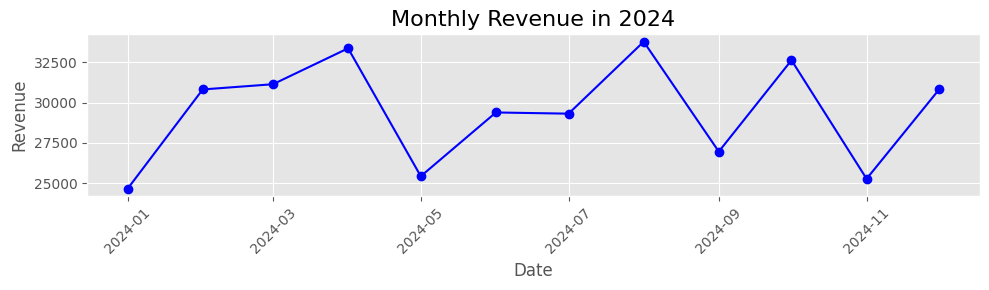

In [36]:
# in order to graph easier we set date as the index
monthly_revenue.set_index('date', inplace=True)

# we make the graph
plt.figure(figsize=(10, 3))
plt.plot(monthly_revenue.index, monthly_revenue['revenue'], marker='o', linestyle='-', color='b')
plt.title('Monthly Revenue in 2024', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### DataFrame revenue by category

In [37]:
# group by category and month and sum the revenues
category_revenue = historical.groupby(['main_category', 'month'])['revenue (USD)'].sum().reset_index()

category_revenue['month'] = category_revenue['month'].dt.to_timestamp()
category_revenue= category_revenue.rename(columns={'month': 'date', 'revenue (USD)': 'revenue'})
category_revenue


,main_category,date,revenue
0,accessories,2024-01-01,12837
1,accessories,2024-02-01,18303
2,accessories,2024-03-01,17150
3,accessories,2024-04-01,20334
4,accessories,2024-05-01,15372
5,accessories,2024-06-01,15999
6,accessories,2024-07-01,18452
7,accessories,2024-08-01,17486
8,accessories,2024-09-01,17163
9,accessories,2024-10-01,19481


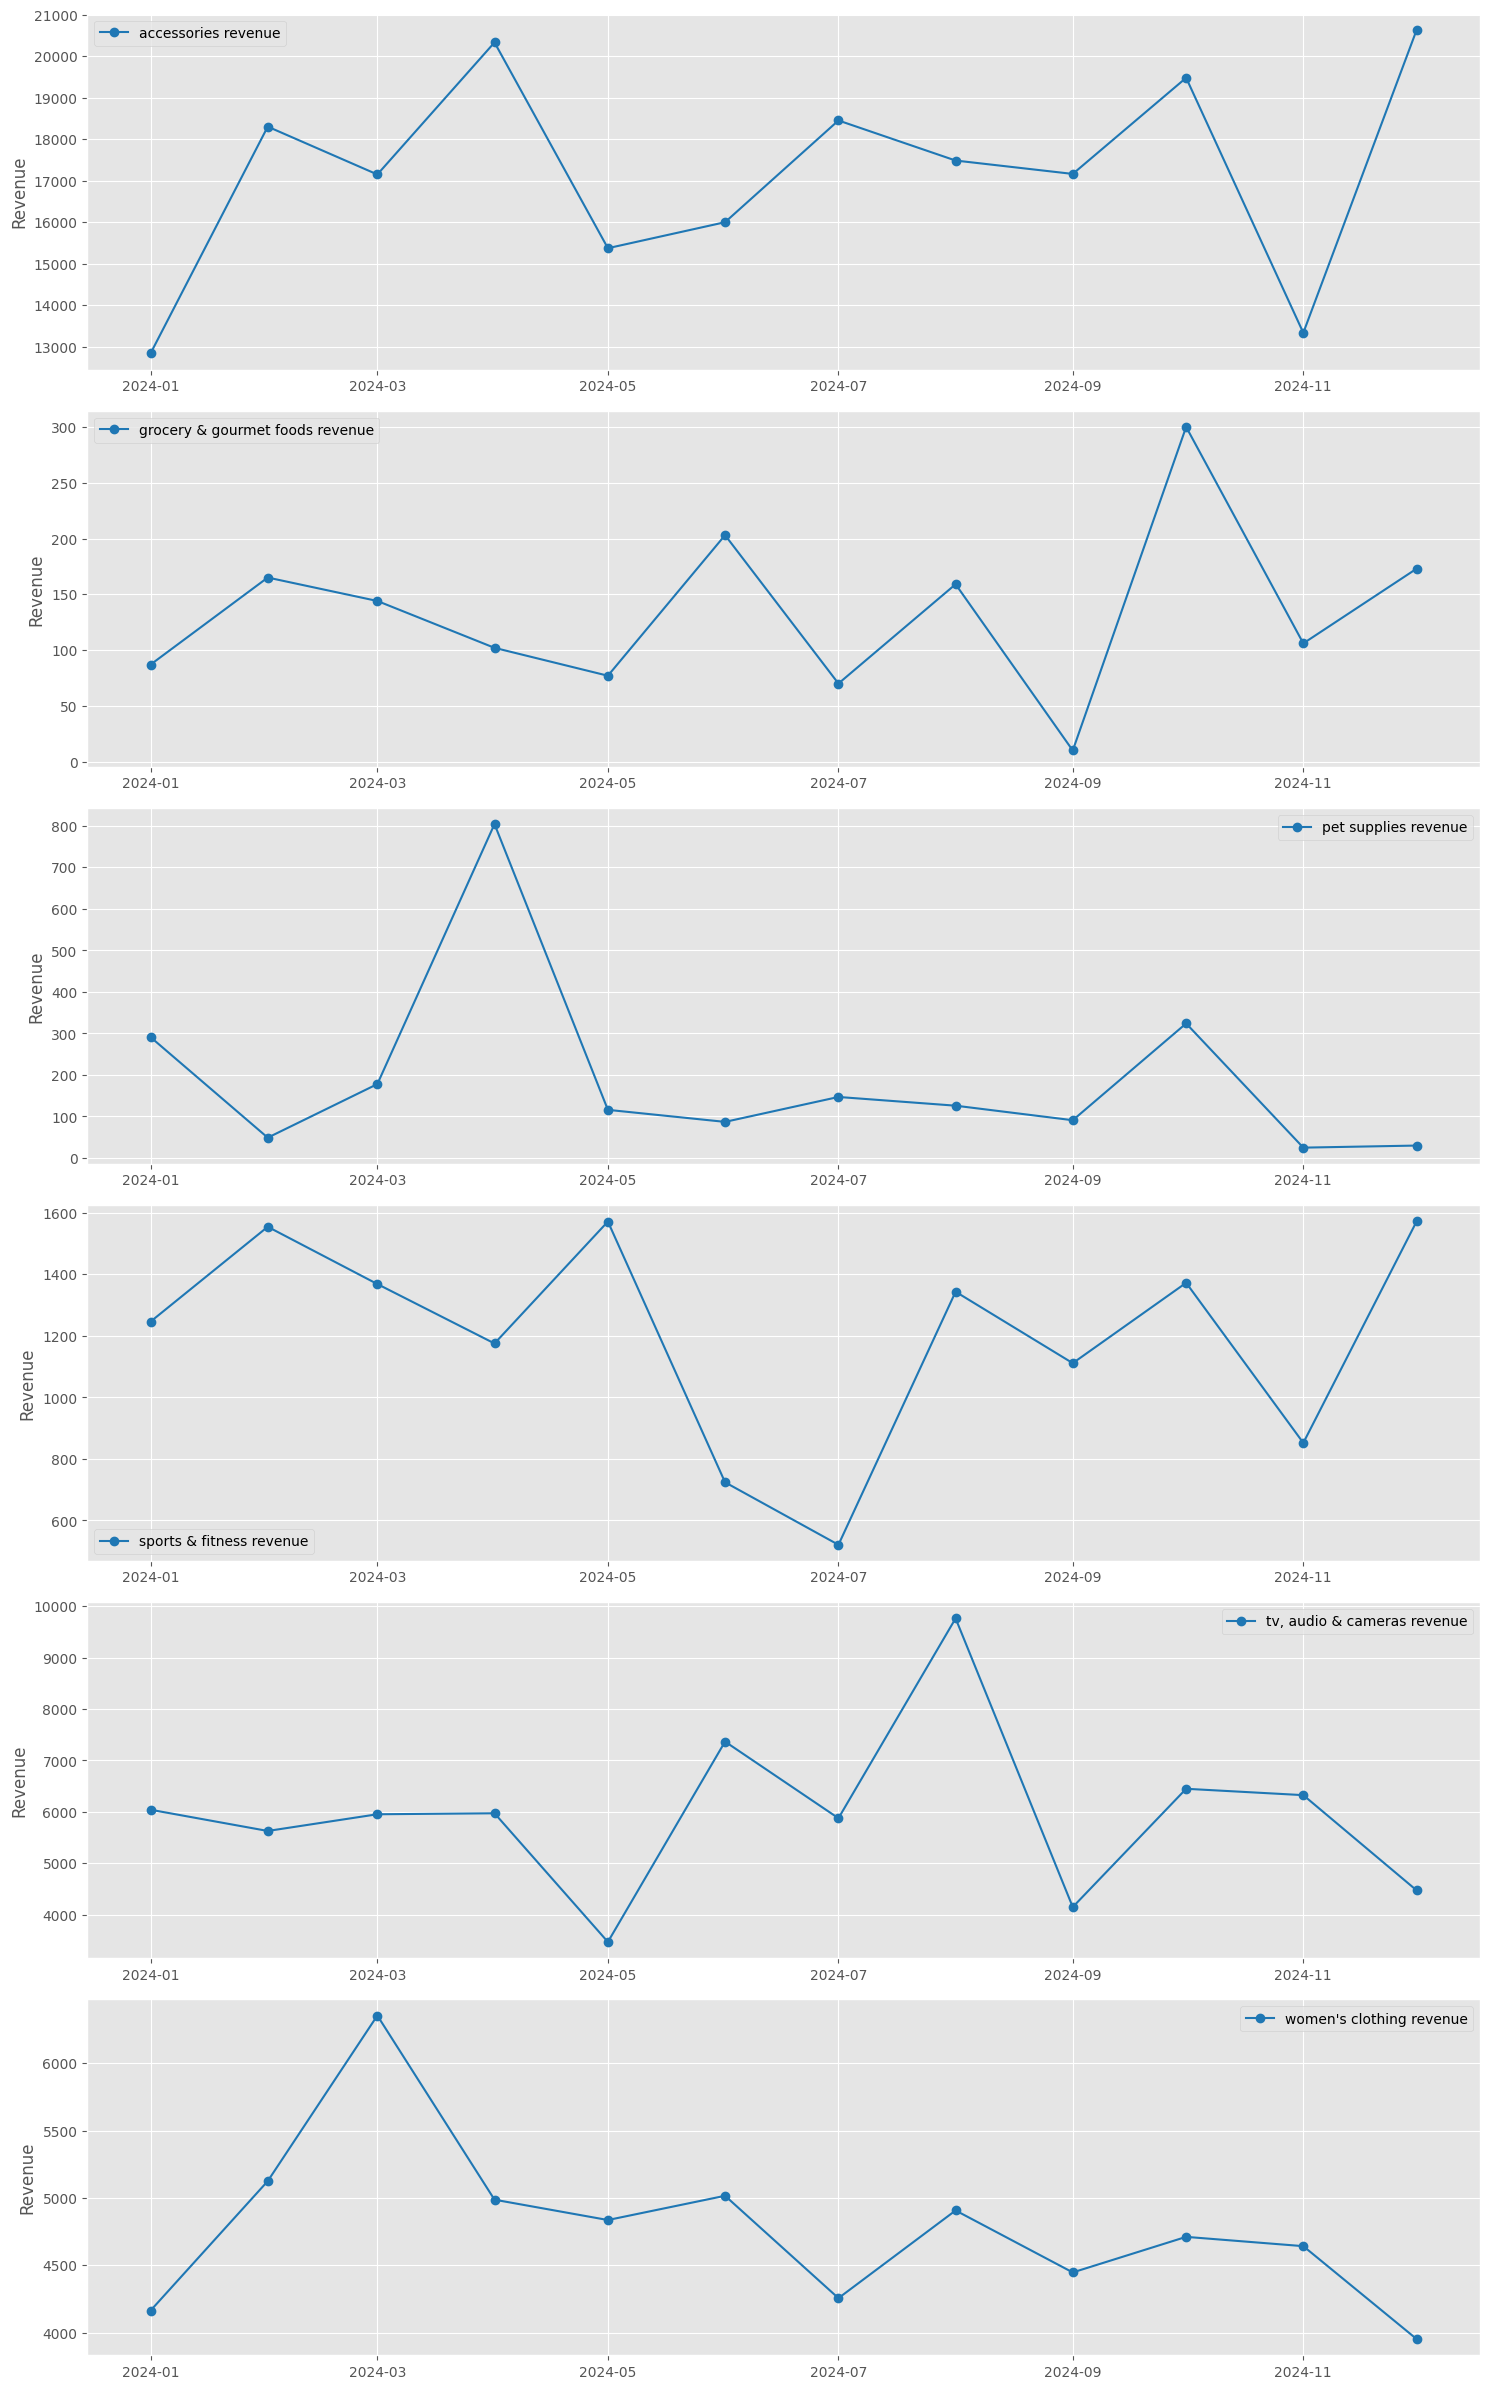

In [38]:
# get the unique categories
categories = category_revenue['main_category'].unique()

# make the plot
fig, axes = plt.subplots(len(categories), 1, figsize=(15, len(categories) * 4), sharex=False, sharey=False)

for i, category in enumerate(categories):
    category_data = category_revenue[category_revenue['main_category'] == category]
    axes[i].plot(category_data['date'], category_data['revenue'], marker='o', label=f'{category} revenue', color='tab:blue')
    axes[i].set_ylabel('Revenue')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

<a id='model'></a>
## Model implementation
[Back to index](#index)

In this section, we implement basic models that will serve as benchmarks (as an example, other models such as ARIMA could be used, although we have very little historical data to build a reliable ARIMA model, and even XGBoost if we find that seasonality is not significant)

### Prediction of total monthly revenue with ARIMA model

In [39]:
# in order to aply ARIMA model, we need the time series to be stationary, wich is the case
check_stationary = monthly_revenue.copy()
check_stationary["revenue_log"] = check_stationary["revenue"].apply(np.log1p)
check_stationary["revenue_log_diff"] = check_stationary["revenue_log"].diff()
check_stationary

,revenue,revenue_log,revenue_log_diff
date,,,
2024-01-01,24664,10.113141,NaN
2024-02-01,30822,10.336016,0.222876
2024-03-01,31145,10.346441,0.010425
2024-04-01,33372,10.415502,0.069061
2024-05-01,25438,10.144039,-0.271464
2024-06-01,29394,10.288580,0.144541
2024-07-01,29320,10.286059,-0.002521
2024-08-01,33784,10.427772,0.141713
2024-09-01,26967,10.202406,-0.225366


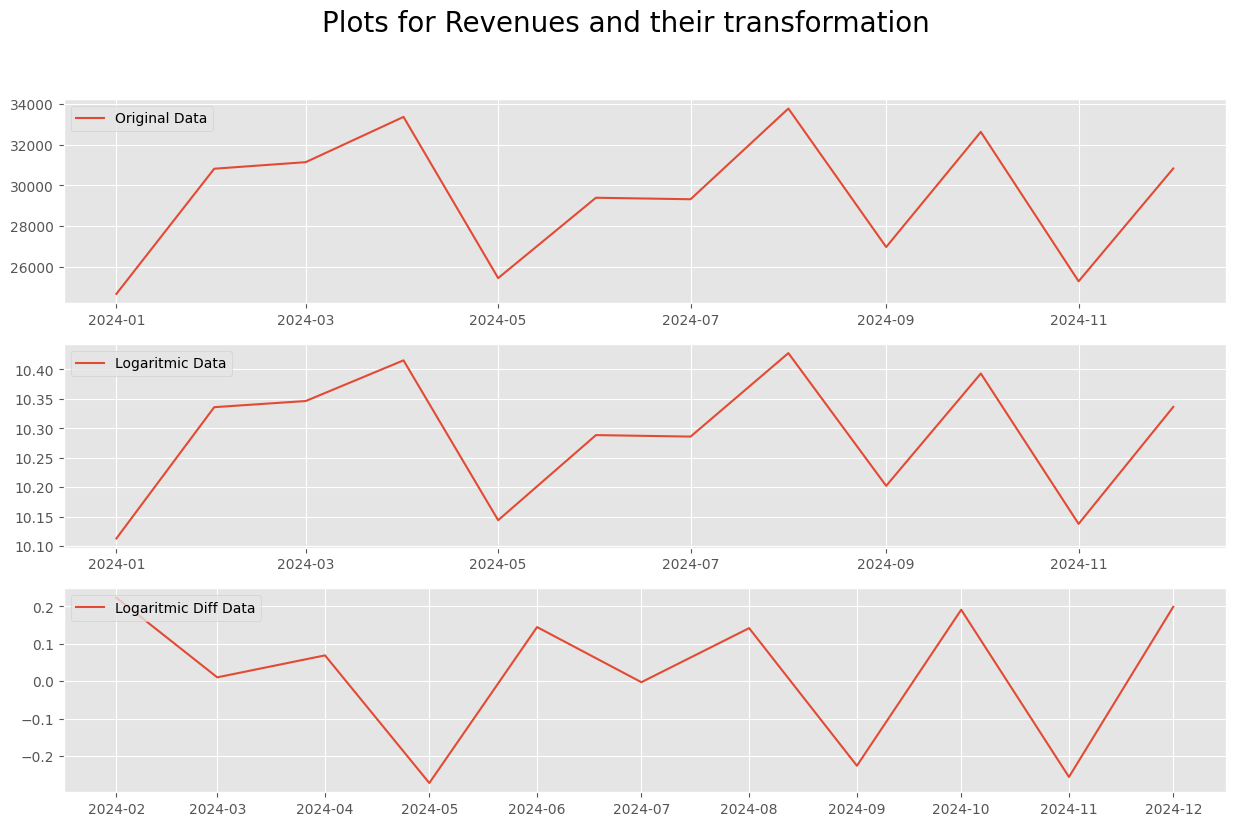

In [40]:
# we plot a graphic in wich we verify the time series is stationary
fig = plt.figure(figsize = (15, 9))
ax1, ax2, ax3 = fig.subplots(3, 1)
# plotting part
ax1.plot(check_stationary["revenue"], label = "Original Data")
ax2.plot(check_stationary["revenue_log"], label = "Logaritmic Data")
ax3.plot(check_stationary["revenue_log_diff"], label = "Logaritmic Diff Data")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper left")
ax3.legend(loc = "upper left")

fig.suptitle("Plots for Revenues and their transformation", fontsize = 20);

One of the most commonly used tests in order to now if a time series is stationary is the [Augmented Dickey–Fuller Test].
The intuition behind the test is that it examines whether the time series has a unit root or not.
In practice, we focus on the p-value of the test, and if it is below 0.05, the series is considered stationary.

In [41]:
resultado_analisis = adfuller(check_stationary["revenue"])
    
p_valor = round(resultado_analisis[1], 3)
    
print("Significance level to consider the series stationary: {}".format(0.05))
print("p-value: {}\n".format(p_valor))

Significance level to consider the series stationary: 0.05
p-value: 0.002



In [42]:
monthly_revenue

,revenue
date,
2024-01-01,24664
2024-02-01,30822
2024-03-01,31145
2024-04-01,33372
2024-05-01,25438
2024-06-01,29394
2024-07-01,29320
2024-08-01,33784
2024-09-01,26967


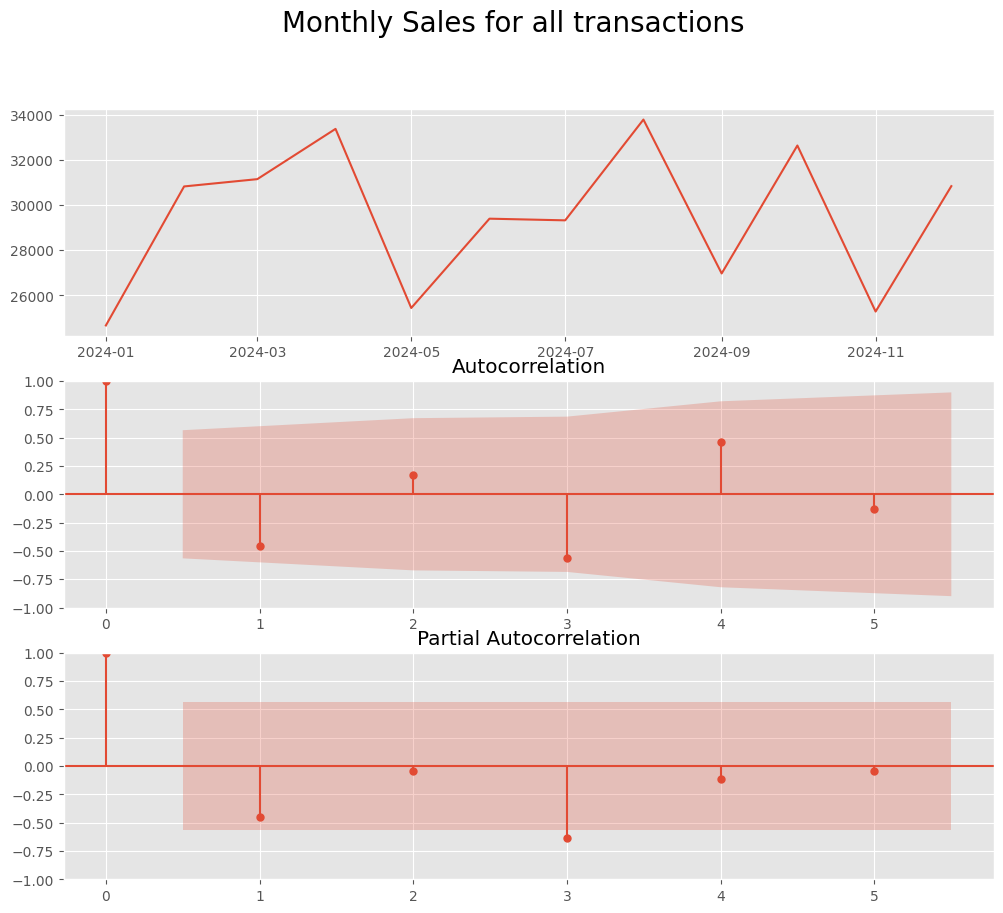

In [43]:
# plot the acf_pacf in order to know approximately the values of p and q that we need for our SARIMAX model

def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 5)
    plot_pacf(x = y, ax = ax3, lags = 5)

    plt.suptitle(t = title, fontsize = 20)

plot_ts_acf_pacf(monthly_revenue,'Monthly Sales for all transactions')

In [44]:
y_train_arima = check_stationary['revenue'].iloc[:-1]
y_test_arima = check_stationary['revenue'].iloc[-1:]

pdq = [
    (0, 0, 3),
    (0, 0, 3),
    
    (1, 0, 3),
    (1, 0, 3),

    (3, 0, 3),
    (3, 0, 3),
    
    (0, 1, 3),
    (0, 1, 3),
    
    (1, 1, 3),
    (1, 1, 3),

    (3, 1, 3),
    (3, 1, 3)
]


seasonal_pdq = (0, 0, 0, 0)

In [45]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = y_train_arima,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))
    
    RESULTS_DICT[param] = round(model_fitted.aic, 2)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Loca

ARIMA(0, 0, 3)x(0, 0, 0, 0)12 - AIC:299.6851152876125
ARIMA(0, 0, 3)x(0, 0, 0, 0)12 - AIC:299.6851152876125
ARIMA(1, 0, 3)x(0, 0, 0, 0)12 - AIC:139.09462192094944
ARIMA(1, 0, 3)x(0, 0, 0, 0)12 - AIC:139.09462192094944


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\P

ARIMA(3, 0, 3)x(0, 0, 0, 0)12 - AIC:140.73829075498045
ARIMA(3, 0, 3)x(0, 0, 0, 0)12 - AIC:140.73829075498045
ARIMA(0, 1, 3)x(0, 0, 0, 0)12 - AIC:288.1226007742505


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\U

ARIMA(0, 1, 3)x(0, 0, 0, 0)12 - AIC:288.1226007742505
ARIMA(1, 1, 3)x(0, 0, 0, 0)12 - AIC:124.40562576640838
ARIMA(1, 1, 3)x(0, 0, 0, 0)12 - AIC:124.40562576640838
ARIMA(3, 1, 3)x(0, 0, 0, 0)12 - AIC:127.5487445313342
ARIMA(3, 1, 3)x(0, 0, 0, 0)12 - AIC:127.5487445313342


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# gridsearch x y gridsearch y
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
Minimum score is raised with ARIMA{pdq_min_score_aic}
With a AIC score of {min_score_aic}.
In the position {idx_min_score_aic}
'''

print(message)


Minimum score is raised with ARIMA(1, 1, 3)
With a AIC score of 124.41.
In the position 4



In [47]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = y_train_arima,
    order = pdq_min_score_aic,
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
pred_uc = best_arima_model_fitted.get_forecast(steps = 2)
y_pred_arima = pred_uc.predicted_mean
y_pred_arima

2024-12-01    34084.371835
2025-01-01    23982.313283
Freq: MS, Name: predicted_mean, dtype: float64

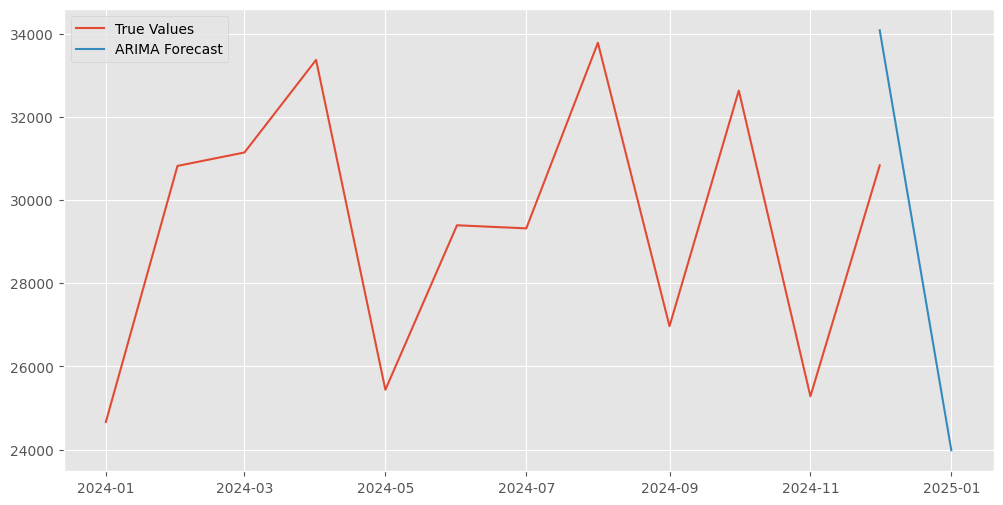

In [49]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(check_stationary['revenue'], label = "True Values")
ax.plot(y_pred_arima, label = "ARIMA Forecast")

ax.legend(loc = "upper left")

We observe that the difference is significant, so we should adjust the parameters and further refine the model to obtain more realistic and meaningful results. However, as a benchmark, it serves as a very good initial model.

### Prediction of total monthly revenue with Prophet model

In [50]:
monthly_revenue = monthly_revenue.reset_index()
monthly_prophet = monthly_revenue.rename(columns={'date': 'ds', 'revenue': 'y'})
monthly_prophet

,ds,y
0,2024-01-01,24664
1,2024-02-01,30822
2,2024-03-01,31145
3,2024-04-01,33372
4,2024-05-01,25438
5,2024-06-01,29394
6,2024-07-01,29320
7,2024-08-01,33784
8,2024-09-01,26967
9,2024-10-01,32635


In [51]:
prophet = Prophet()

# train our model
prophet.fit(monthly_prophet)

# we predict the data we want, in this case, the next month
future_df = prophet.make_future_dataframe(periods = 1, freq = "M", include_history = True)
y_pred_prophet = prophet.predict(future_df)

10:32:24 - cmdstanpy - INFO - Chain [1] start processing
10:32:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [52]:
y_pred_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-01,29064.983312,24800.570116,33187.444481,29064.983312,29064.983312,0.0,0.0,0.0,0.0,0.0,0.0,29064.983312
1,2024-02-01,29141.574998,25428.836881,33484.799164,29141.574998,29141.574998,0.0,0.0,0.0,0.0,0.0,0.0,29141.574998
2,2024-03-01,29213.225286,25207.394158,32852.833775,29213.225286,29213.225286,0.0,0.0,0.0,0.0,0.0,0.0,29213.225286
3,2024-04-01,29289.816972,25111.695771,33035.554017,29289.816972,29289.816972,0.0,0.0,0.0,0.0,0.0,0.0,29289.816972
4,2024-05-01,29363.937957,25668.052002,33371.725543,29363.937957,29363.937957,0.0,0.0,0.0,0.0,0.0,0.0,29363.937957
5,2024-06-01,29440.529642,25425.390075,33450.265610,29440.529642,29440.529642,0.0,0.0,0.0,0.0,0.0,0.0,29440.529642
6,2024-07-01,29514.650628,25385.530503,33657.672697,29514.650628,29514.650628,0.0,0.0,0.0,0.0,0.0,0.0,29514.650628
7,2024-08-01,29591.242314,25662.559891,33482.384241,29591.242314,29591.242314,0.0,0.0,0.0,0.0,0.0,0.0,29591.242314
8,2024-09-01,29667.833999,25740.526912,33340.477658,29667.833999,29667.833999,0.0,0.0,0.0,0.0,0.0,0.0,29667.833999
9,2024-10-01,29741.954985,26015.451705,33665.826223,29741.954985,29741.954985,0.0,0.0,0.0,0.0,0.0,0.0,29741.954985


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


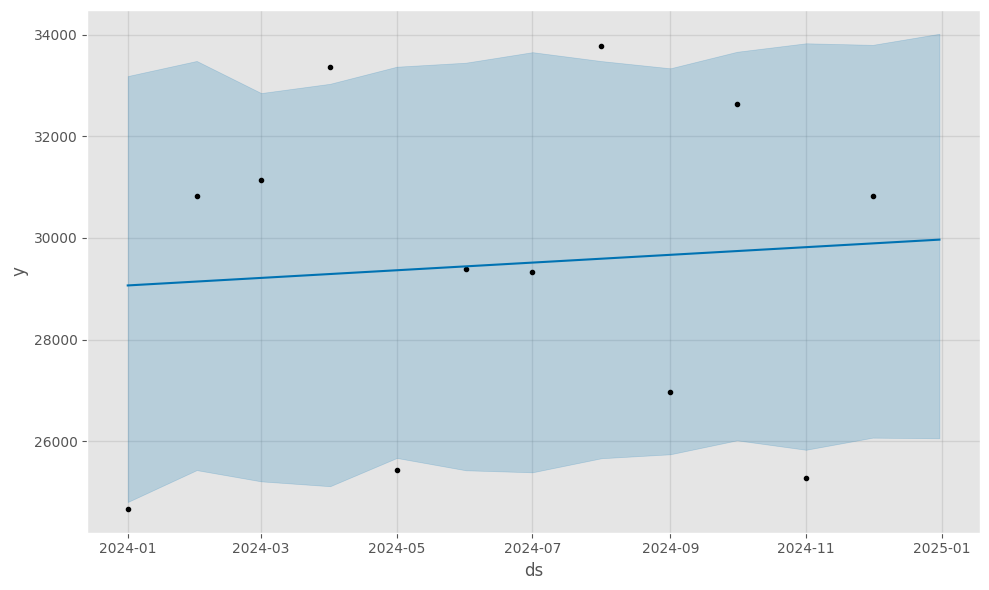

In [53]:
# we plot the results
prophet.plot(y_pred_prophet);

In [54]:
# select the columns we want: time(ds) and revenue(yhat)
predictions = y_pred_prophet[['ds', 'yhat']]

# merge the original data with the predicted ones
combined_df = pd.merge(predictions,monthly_prophet, on='ds', how='left')
combined_df

,ds,yhat,y
0,2024-01-01,29064.983312,24664.0
1,2024-02-01,29141.574998,30822.0
2,2024-03-01,29213.225286,31145.0
3,2024-04-01,29289.816972,33372.0
4,2024-05-01,29363.937957,25438.0
5,2024-06-01,29440.529642,29394.0
6,2024-07-01,29514.650628,29320.0
7,2024-08-01,29591.242314,33784.0
8,2024-09-01,29667.833999,26967.0
9,2024-10-01,29741.954985,32635.0


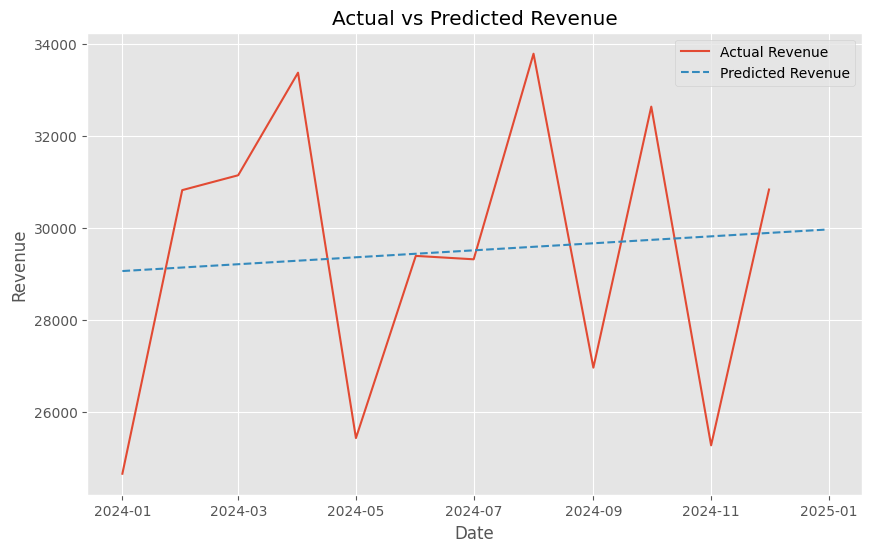

In [55]:
# plot the graphics
plt.figure(figsize=(10, 6))
plt.plot(combined_df['ds'], combined_df['y'], label='Actual Revenue')
plt.plot(combined_df['ds'], combined_df['yhat'], label='Predicted Revenue', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

### Revenue forecast by category

In this section, it would be sufficient to implement a function that trains and applies the selected model for each category in the dataset we previously created. This function should be capable of iterating through the different categories, adjusting the model specifically for each one, considering the particular characteristics of their data. In this way, we could obtain individual revenue predictions for each category and, by summing them, calculate the expected total revenue.